In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## 数据

x_train.shape: (70, 2)
y_train.shape: (70, 1)


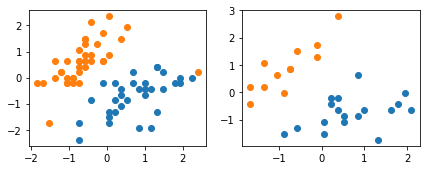

In [2]:
df = pd.read_csv("../data/iris.data", sep=",")
data = df.to_numpy()

x = data[:100, :2].astype(np.float)
y = np.zeros(100)
y[50:] = 1

n, m = x.shape
shuffle_idx = np.random.permutation(n)
x, y = x[shuffle_idx], y[shuffle_idx]

x_train, x_test = x[:70], x[70:]
y_train, y_test = y[:70], y[70:]

mu, std = np.mean(x_train, axis=0), np.std(x_train, axis=0)
x_train, x_test = (x_train - mu) / std, (x_test - mu) / std
y_train, y_test = y_train.reshape((-1, 1)), y_test.reshape((-1, 1))
print('x_train.shape:', x_train.shape)
print('y_train.shape:', y_train.shape)

fig, ax = plt.subplots(1, 2, figsize=(7, 2.5))
ax[0].scatter(x_train[y_train[:, 0] == 1, 0], x_train[y_train[:, 0] == 1, 1])
ax[0].scatter(x_train[y_train[:, 0] == 0, 0], x_train[y_train[:, 0] == 0, 1])
ax[1].scatter(x_test[y_test[:, 0] == 1, 0], x_test[y_test[:, 0] == 1, 1])
ax[1].scatter(x_test[y_test[:, 0] == 0, 0], x_test[y_test[:, 0] == 0, 1])
plt.show()

In [3]:
def nextbatch(data, batch_size, shuffle=False, seed=None):
    rstate = np.random.RandomState(seed)
    indices = np.arange(data[0].shape[0])
    
    if shuffle:
        rstate.shuffle(indices)
    # 
    for start_idx in range(0, indices.shape[0] - batch_size + 1, batch_size):
        index_slice = indices[start_idx: start_idx + batch_size]
        
        yield (arr[index_slice] for arr in data)

## 参数

In [4]:
n_samples = x.shape[0]
n_features = x.shape[1]

learning_rate = 0.05
epochs = 15
batch_size = 10

## 模型

In [5]:
g = tf.Graph()
with g.as_default() as g:
    # input
    X = tf.placeholder(dtype=tf.float32, shape=[None, n_features], name="X")
    # output
    Y = tf.placeholder(dtype=tf.float32, shape=[None, 1], name="Y")
    
    # weights
    weights = tf.Variable(tf.truncated_normal(shape=[n_features, 1]), dtype=tf.float32, name="W")
    bias = tf.Variable(tf.zeros([1]), dtype=tf.float32, name="b")
    
    # model
    linear = tf.add(tf.matmul(X, weights), bias)
    pred = tf.sigmoid(linear, name = "prediction")
    
    # cost
    cost = tf.reduce_mean(-tf.reduce_sum(Y*tf.log(pred) + (1-Y)*tf.log(1-pred)), name="cost")
    
    # optimizer
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(cost)
    
    # metrics
    pred_labels = tf.round(pred, name='predict_labels')
    assert(Y.get_shape().as_list() == pred.get_shape().as_list())
    correct_prediction = tf.equal(tf.cast(Y, tf.int64), tf.cast(pred_labels, tf.int64))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='accuracy')

## train

In [6]:
with tf.Session(graph=g) as sess:
    sess.run(tf.global_variables_initializer())
    
    avg_cost = np.nan
    count = 1
    
    for epoch in range(epochs):
        train_acc = sess.run(accuracy, feed_dict={X: x_train, Y: y_train})
        valid_acc = sess.run(accuracy, feed_dict={X: x_test, Y: y_test}) 

        print("Epoch: %03d | AvgCost: %.3f" % (epoch, avg_cost / count), end="")
        print(" | Train/Valid ACC: %.2f/%.2f" % (train_acc, valid_acc))
        
        avg_cost = 0.
        for x_batch, y_batch in nextbatch(data=[x_train, y_train],
                                                    batch_size=batch_size, 
                                                    shuffle=True, seed=123):
            
            _, c = sess.run([train_op, cost], feed_dict={X: x_batch, Y: y_batch})

            avg_cost += c
            count += 1

    w, b = sess.run([weights, bias])
    print('\nWeights:\n', w)
    print('\nBias:\n', b)

Epoch: 000 | AvgCost: nan | Train/Valid ACC: 0.03/0.00
Epoch: 001 | AvgCost: 5.421 | Train/Valid ACC: 0.97/1.00
Epoch: 002 | AvgCost: 1.475 | Train/Valid ACC: 0.97/1.00
Epoch: 003 | AvgCost: 0.774 | Train/Valid ACC: 0.97/1.00
Epoch: 004 | AvgCost: 0.512 | Train/Valid ACC: 0.97/1.00
Epoch: 005 | AvgCost: 0.380 | Train/Valid ACC: 0.97/1.00
Epoch: 006 | AvgCost: 0.301 | Train/Valid ACC: 0.96/1.00
Epoch: 007 | AvgCost: 0.249 | Train/Valid ACC: 0.96/1.00
Epoch: 008 | AvgCost: 0.212 | Train/Valid ACC: 0.96/1.00
Epoch: 009 | AvgCost: 0.185 | Train/Valid ACC: 0.96/1.00
Epoch: 010 | AvgCost: 0.164 | Train/Valid ACC: 0.96/1.00
Epoch: 011 | AvgCost: 0.147 | Train/Valid ACC: 0.96/1.00
Epoch: 012 | AvgCost: 0.134 | Train/Valid ACC: 0.96/1.00
Epoch: 013 | AvgCost: 0.122 | Train/Valid ACC: 0.96/1.00
Epoch: 014 | AvgCost: 0.113 | Train/Valid ACC: 0.96/1.00

Weights:
 [[ 2.4281611]
 [-2.417197 ]]

Bias:
 [-0.3186389]


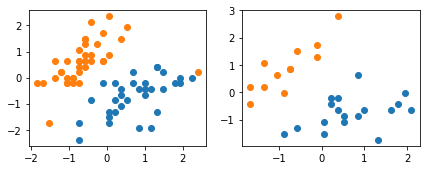

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(7, 2.5))
ax[0].scatter(x_train[y_train[:, 0] == 1, 0], x_train[y_train[:, 0] == 1, 1])
ax[0].scatter(x_train[y_train[:, 0] == 0, 0], x_train[y_train[:, 0] == 0, 1])
ax[1].scatter(x_test[y_test[:, 0] == 1, 0], x_test[y_test[:, 0] == 1, 1])
ax[1].scatter(x_test[y_test[:, 0] == 0, 0], x_test[y_test[:, 0] == 0, 1])


plt.show()